# NSQIP - LASSO Regression
---

Regressing on all of our predictors at once will tend to produce an over-fitted model. A traditional approach to this is to use a stepwise selection procedure, fitting individual best-fitting terms in sequence and adding them to build up a model in an interative fashion. These models are pretty common in the literature, but statisticians tend not to like them for a variety of reasons. Some of these are technical, but a pretty basic reason is that doing dozens of repeated statistical tests makes the meaning of each statistical test less valid.

A more modern approach is to use a regularization term in the regression that penalizes the model fit based on the size of coefficients. Popular ways of doing this include Ridge Regression, Lasso Regression, and Elastic Net Regression. Ridge Regression uses a penalty based on the $L^2$ norm of the vector of coefficients (which is just the euclidean length of the coefficient vector). Lasso Regression uses a penalty based on the $L^1$ norm (which is the sum of the absolute values of the coefficients). Elastic Net Regression uses a combination of $L^1$ and $L^2$ penalties. Given covarying predictors, Lasso regression will tend to fit based on one of them, and shrink the others to zero, giving a sparse model. More information can be found here: 

[Tibshirani, R. (1996). Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society. Series B (Methodological), 267-288.](http://www.jstor.org.ezp-prod1.hul.harvard.edu/stable/2346178)

Begin with imports of key libraries, and load the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import statsmodels.discrete.discrete_model as sm
import sklearn.metrics as sklm
import random
import warnings 
import math
warnings.filterwarnings("ignore") # Ignore annoying warnings

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

Next, determine which response and predictor columns we want to use.

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Either drop or keep columns from cdf
dropOrKeep = False
if dropOrKeep:
    dropList = ['READMISSION-','READMISSION1-','REOPERATION-',\
                'REOPERATION1-','NWNDINFD-','WNDINFD-','DEHIS-','NDEHIS-',\
                'MORBPROB','NSUPINFEC-','SUPINFEC-','RETORPODAYS','OTHSYSEP',\
                'NOTHSYSEP-']
    colsToDrop = [colName for colName in cdf.columns if np.any([dropItem in colName for dropItem in dropList])]
    cdf = cdf.drop(colsToDrop,1)
    print('Dropped some variables: ')
    print(colsToDrop)
    # These are being dropped automatically by Imputer
    colsToDrop = [ 4,5,6,16,17,18,137,191,192,193,194,195,212,213,214,236,237,238,\
                  239,284,285,316,317,350,351,411,412,413,414,505,506,507,514,517]
    cdf = cdf.drop(cdf.columns[colsToDrop],axis=1)
    
else:
    # Dropping these columns is super-cumbersome. Let's find a list to keep
    # Need to add FNSTATUS1 and RBC
    keepList = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','DIABETES',\
                'SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT','HXCOPD','CPNEUMON',\
                'HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED','HXPVD','RENAFAIL','DIALYSIS',\
                'CVA','DISCANCR','WNDINF','STEROID','WTLOSS','BLEEDDIS','PROPER30','ASACLASS',\
                'ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH','PRWBC'\
                'PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY']
    colsToKeep = [colName for colName in cdf.columns if np.any([keepItem in colName for keepItem in keepList])]
    cdf = cdf[colsToKeep]

These regression models will fail on missing data, so we'll impute missing data for each column by setting it equal to the mean.

Since our regularization penalty is based on the size of the coefficients, we need to scale each column to have approximately equal mean and variance. We also add an intercept column.

In [3]:
# Add an intercept
cdf['intercept'] = 1.0

# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
cdf = pd.DataFrame(X, columns=colNames)

# Scale the columns
X = StandardScaler().fit_transform(cdf)
scaledX = pd.DataFrame(X, columns=colNames)

We break the data into separate fractions for training and testing. All of our fitting and cross-validation will be done on the training set. The testing set will be held out to evaluate the final model performance.

In [4]:
# Split for cross-validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.33)

We'll create a LogisticRegression object with $L^1$ regularization, corresponding to LASSO.

We need to determine the appropriate value of the regularization strength $C$. To do this we'll do a cross-validated grid search, trying different values of $C$, and calculating the ROC AUC on the held-out cross-validation fraction. (Nb. This is not using the 'test' data held out above.)

We need to find some way here to determine confidence intervals on the regression parameters. How to do this well is still an area of active research (see references below), and it's still the Wild West in terms of how it's deployed in the biomedical literature. We'll take a pretty naive approach based on bootstrap resampling cases and refitting the LASSO. In practice this works pretty well: it seems to suggest a handful of terms in the final model aren't reliably signficant, but it doesn't seem like the LASSO often misses terms that should be.

We can back this up by doing a straight-up (not regularized) multiple regression using the variables selected by the final LASSO. However, because this procedure benefits from the variable selection of the LASSO but not its shrinkage, we expect that it will produce larger coefficients and probably overstate p-values.

Some references on bootstrapping LASSO and other model selection techniques:

Chatterjee, A., & Lahiri, S. N. (2011). Bootstrapping lasso estimators. Journal of the American Statistical Association, 106(494), 608-625.

Lee, J. D., Sun, D. L., Sun, Y., & Taylor, J. E. (2016). Exact post-selection inference, with application to the lasso. The Annals of Statistics, 44(3), 907-927.

Efron, B. (2014). Estimation and accuracy after model selection. Journal of the American Statistical Association, 109(507), 991-1007.

Zhang, J., Jeng, X. J., & Liu, H. (2008). Some two-step procedures for variable selection in high-dimensional linear regression. arXiv preprint arXiv:0810.1644.


In [5]:
# Do logistic regression, use L1 penalty, for LASSO
# Whenever we fit to a sample of data, we'll search through the values
# of the regularization strength C that give the highest ROC AUC on 
# held-out cross-validation data from that sample.
lr = LogisticRegression(C=0.01, penalty='l1', tol=0.01)
tuned_parameters = [{'C': np.logspace(-2.5,-.5,20,base=10)}]
gscv = GridSearchCV(lr,tuned_parameters,cv=10,scoring='roc_auc',verbose=0)

# Bootstrap this whole regression
nBoots = 10
nSamp = X_train.shape[0]
nPred = X_train.shape[1]
bootParams = np.empty((nBoots, nPred))
bootCs = np.empty((nBoots,1))
# For each bootstrap sample
for bootN in np.arange(nBoots):
    # Draw a collection of observations from the training set with replacement
    sampIdx = [random.randint(0,nSamp-1) for n in np.arange(nSamp)]
    y_boot = y_train[sampIdx]
    X_boot = X_train.iloc[sampIdx,:]
    
    # Fit the model to the bootstrap sample. 
    gscv.fit(X_boot, y_boot)
    
    # Store the coefficients (and the best C values) for each bootstrapped sample
    coeffs = gscv.best_estimator_.coef_.ravel()
    bootParams[bootN,:] = coeffs
    bootCs[bootN] = gscv.best_params_['C']
    print('Booted #%d/%d with C: %.3f' % (bootN+1, nBoots, bootCs[bootN]))

Booted #0/10 with C: 0.028
Booted #1/10 with C: 0.022
Booted #2/10 with C: 0.058
Booted #3/10 with C: 0.028
Booted #4/10 with C: 0.120
Booted #5/10 with C: 0.094
Booted #6/10 with C: 0.074
Booted #7/10 with C: 0.094
Booted #8/10 with C: 0.074
Booted #9/10 with C: 0.195


In [6]:
# Now that we've bootstrapped, we can fit the model to the actual training data sample
gscv.fit(X_train, y_train)
bestEst = gscv.best_estimator_
coeffs = bestEst.coef_.ravel()
print('Best C: %.3f' % gscv.best_params_['C'])

Best C: 0.058


In [7]:
# Identify confidence intervals from the parameters fit to the bootstrapped samples
lciIdx = round(.025*(nBoots-1))
uciIdx = round(.975*(nBoots-1))
bootParams.shape
bootParams.sort(axis=0)
lowCI = bootParams[lciIdx,:]
upCI  = bootParams[uciIdx,:]
allCols = [(coeffs[index], lowCI[index], upCI[index], colName) for index, colName\
           in enumerate(X_boot.columns)]

Now print out significant coefficients. Remember that variables have been scaled, so coefficient size is a good measure of effect size, but we need to transform them back to get them in natural units.

In [8]:
# Print out the coefficient if it was included in the final model
# ... or if it was significant in the bootstrap.
print('--- Terms in final model, and significant ---')
for item in allCols:
    if (item[0] != 0) and ((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)
print('--- Terms in final model, and NOT significant ---')
for item in allCols:
    if (item[0] != 0) and ~((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)
print('--- Terms NOT in final model, and significant ---')
for item in allCols:
    if (item[0] == 0) and ((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)
print('--- Terms NOT in final model, and NOT significant ---')
for item in allCols:
    if (item[0] == 0) and ~((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)

--- Terms in final model, and significant ---
Coeff: +0.284 [+0.156, +0.513] AGE  
Coeff: +0.116 [+0.077, +0.243] DIABETES-INSULIN  
Coeff: +0.052 [+0.002, +0.124] DIALYSIS-Yes  
Coeff: +0.230 [+0.023, +0.285] NWNDINFD-0  
Coeff: -0.109 [-0.165, -0.073] PRALBUM  
Coeff: +0.088 [+0.050, +0.126] PRALKPH  
Coeff: -0.033 [-0.235, -0.017] WNDINFD-Deep Incisional SSI  
--- Terms in final model, and NOT significant ---
Coeff: -0.033 [-0.207, +0.000] ANESTHES-Spinal  
Coeff: -0.007 [-0.035, +0.000] ANESTHES_OTHER-General  
Coeff: +0.086 [+0.000, +0.179] ANESTHES_OTHER-Spinal  
Coeff: +0.009 [+0.000, +0.049] CNSCVA-No Complication  
Coeff: +0.038 [+0.000, +0.124] CVA-Yes  
Coeff: -0.034 [-0.053, +0.000] DCNSCVA-0.0  
Coeff: -0.105 [-0.155, +0.000] DIABETES-NO  
Coeff: +0.049 [+0.000, +0.131] DPRINR  
Coeff: -0.014 [-0.066, +0.000] DPRPT  
Coeff: +0.013 [+0.000, +0.144] DPRPTT  
Coeff: +0.009 [-0.020, +0.078] DWNDINFD  
Coeff: +0.038 [+0.000, +0.074] DYSPNEA-AT REST  
Coeff: -0.019 [-0.142, +0.0

Now plot the mean cross-validated AUC for each value of $C$ we tried for the final model. The model uses the best value of $C$ (dotted line).

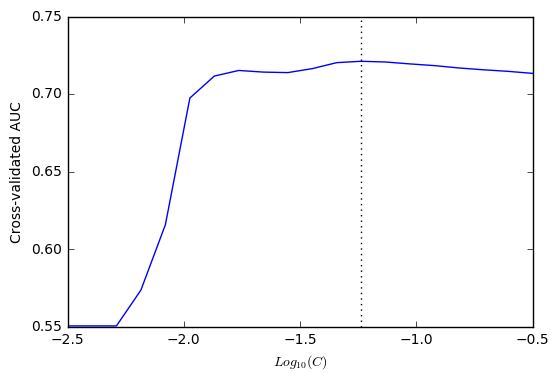

In [9]:
gscv.grid_scores_
means = [mean_score for params, mean_score, scores in gscv.grid_scores_]
Cs = [params['C'] for params, mean_score, scores in gscv.grid_scores_]
plt.plot(np.log10(Cs), means)
bestC = gscv.best_params_['C']
ylims = plt.gca().get_ylim()
plt.plot(np.log10([bestC, bestC]),ylims,color='k',ls=':')
plt.ylim(ylims)
plt.xlabel('$Log_{10}(C)$')
plt.ylabel('Cross-validated AUC')
plt.show()

Ok, as an aside, what happens if we just take all the terms from the final regression model, and plug those into a standard (unregularized) logistic regression? It looks like the covariance matrix is singular here, even for just the significant predictors. **We can regularize to make it work, but we need to return and fix this.**

In [50]:
# modelCols = X_train.columns[coeffs != 0].values.tolist()
modelCols = X_train.columns[np.logical_or(lowCI > 0, upCI < 0)].values.tolist()
logit = sm.Logit(y_train, X_train[modelCols])
smresult = logit.fit_regularized(disp=True, alpha=0)  
print(smresult.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.672716103699
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10047
Model:                          Logit   Df Residuals:                    10040
Method:                           MLE   Df Model:                            6
Date:                Wed, 21 Dec 2016   Pseudo R-squ.:                  -4.117
Time:                        14:26:42   Log-Likelihood:                -6758.8
converged:                       True   LL-Null:                       -1320.9
                                        LLR p-value:                     1.000
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------

Plot ROC curves for in-sample training data, and test data. The test data here was not used to fit the model at all, so it should approximate how our model will perform prospectively on new data. Furthermore, if we've done a good job regularizing, the in-sample performance should be pretty close to the test data performance.

In-sample ROC AUC = 0.753 
Test ROC AUC = 0.737 
In-sample LR ROC AUC = 0.722 
Test LR ROC AUC = 0.720 


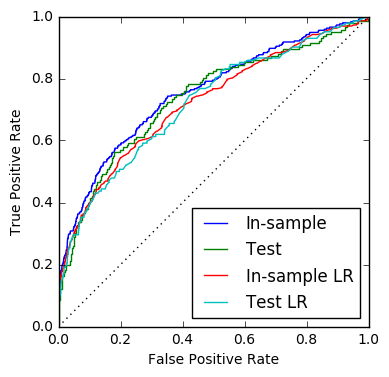

In [56]:
# Plot an ROC curve for training
plt.clf
pred_train = gscv.predict_proba(X_train)[:,1]
rocAUC_train = sklm.roc_auc_score(y_train,pred_train)
print('In-sample ROC AUC = %.3f ' % rocAUC_train)
fpr, tpr, _ = sklm.roc_curve(y_train, pred_train)
plt.figure()
plt.plot(fpr,tpr,label='In-sample')

# Plot an ROC curve for test data
pred_test = gscv.predict_proba(X_test)[:,1]
rocAUC_test = sklm.roc_auc_score(y_test,pred_test)
print('Test ROC AUC = %.3f ' % rocAUC_test)
fpr, tpr, _ = sklm.roc_curve(y_test, pred_test)
plt.plot(fpr,tpr,label='Test')

# Plot an ROC curve for the training data on the LR model
pred_lr_train = smresult.predict(X_train[modelCols])
rocAUC_lr_train = sklm.roc_auc_score(y_train,pred_lr_train)
print('In-sample LR ROC AUC = %.3f ' % rocAUC_lr_train)
fpr, tpr, _ = sklm.roc_curve(y_train, pred_lr_train)
plt.plot(fpr,tpr,label='In-sample LR')

# Plot an ROC curve for the test data on the LR model
pred_lr_test = smresult.predict(X_test[modelCols])
rocAUC_lr_test = sklm.roc_auc_score(y_test,pred_lr_test)
print('Test LR ROC AUC = %.3f ' % rocAUC_lr_test)
fpr, tpr, _ = sklm.roc_curve(y_test, pred_lr_test)
plt.plot(fpr,tpr,label='Test LR')

# Format the ROC plot
plt.plot([0, 1], [0, 1], color='k', linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.show()